
# Turbofan RUL Modeling — NASA CMAPSS (FD001) — **Clean Training Notebook**

This notebook trains and evaluates a Remaining Useful Life (RUL) model for NASA CMAPSS (FD001),
exports the trained artifact, and performs a **sanity-check inference** using the production function `predict_rul`.

**Sections**
1) Setup (paths, imports, seed)  
2) Load raw data (robust)  
3) Target: RUL for training  
4) Feature Engineering (reuse `src/features.py`)  
5) Group-aware CV (by `unit`)  
6) Validation diagnostics (MAE/RMSE + plots)  
7) Train final model & export artifacts  
8) Sanity-check inference (features + raw)  
9) Environment info


In [4]:

import os, sys, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import joblib

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA = ROOT / "data" / "raw"
MODEL_DIR = ROOT / "models"
SRC = ROOT / "src"
sys.path.insert(0, str(SRC))
sys.path.insert(0, str(ROOT))

SEED = 42
random.seed(SEED); np.random.seed(SEED)

print('ROOT     :', ROOT)
print('DATA     :', DATA, '| exists:', DATA.exists())
print('MODEL_DIR:', MODEL_DIR)
print('SRC      :', SRC,  '| exists:', SRC.exists())


ROOT     : /Users/isawgod/Documents/project/turbofan-rul-prediction
DATA     : /Users/isawgod/Documents/project/turbofan-rul-prediction/data/raw | exists: True
MODEL_DIR: /Users/isawgod/Documents/project/turbofan-rul-prediction/models
SRC      : /Users/isawgod/Documents/project/turbofan-rul-prediction/src | exists: True


## 1) Load CMAPSS FD001 (robust reader)

In [5]:

def read_fd(fd: str = "FD001"):
    tr = pd.read_csv(DATA / f"train_{fd}.txt", sep=r"\s+", header=None, engine="python").dropna(axis=1, how="all")
    te = pd.read_csv(DATA / f"test_{fd}.txt",  sep=r"\s+", header=None, engine="python").dropna(axis=1, how="all")
    rl = pd.read_csv(DATA / f"RUL_{fd}.txt",   sep=r"\s+", header=None, engine="python").dropna(axis=1, how="all")
    cols = (["unit","cycle"] + [f"setting_{i}" for i in range(1,4)] + [f"s{i:02d}" for i in range(1,22)])
    tr.columns = cols[:tr.shape[1]]
    te.columns = cols[:te.shape[1]]
    rl.columns = ["RUL"]
    return tr, te, rl

train_raw, test_raw, rul_test = read_fd("FD001")
display(train_raw.head())
print('Shapes:', train_raw.shape, test_raw.shape, rul_test.shape)
print('Units (train/test):', train_raw["unit"].nunique(), "/", test_raw["unit"].nunique())


,unit,cycle,setting_1,setting_2,setting_3,s01,s02,s03,s04,s05,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Shapes: (20631, 26) (13096, 26) (100, 1)
Units (train/test): 100 / 100


## 2) Target Engineering — RUL in training data

In [6]:

max_cycle = train_raw.groupby("unit")["cycle"].transform("max")
train_raw = train_raw.assign(RUL = max_cycle - train_raw["cycle"])
train_raw[["unit","cycle","RUL"]].head()


,unit,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## 3) Feature Engineering — reuse production code (`src/features.py`)

In [7]:

try:
    from src.features import make_features_from_raw, FEATURES
except Exception:
    from features import make_features_from_raw, FEATURES

needed_raw_cols = ["unit","cycle"] + [f"s{i:02d}" for i in range(1,22)]
train_for_fe = train_raw[needed_raw_cols + ["RUL"]].copy()

X_fe = make_features_from_raw(train_for_fe[needed_raw_cols])
y = train_for_fe.loc[X_fe.index, "RUL"].reset_index(drop=True)
X = X_fe.reset_index(drop=True)

print('FEATURES:', FEATURES)
display(X.head())
print('X shape:', X.shape, '| y shape:', y.shape)


FEATURES: ['cycle', 'cycle_norm', 's04', 's11', 's12', 's15', 's17', 's04_rollmean', 's11_rollmean', 's12_rollmean', 's17_rollmean']


,cycle,cycle_norm,s04,s11,s12,s15,s17,s04_rollmean,s11_rollmean,s12_rollmean,s17_rollmean
0,1,0.005208,1400.60,47.47,521.66,8.4195,392,1400.600000,47.470,521.660,392.000000
1,2,0.010417,1403.14,47.49,522.28,8.4318,392,1401.870000,47.480,521.970,392.000000
2,3,0.015625,1404.20,47.27,522.42,8.4178,390,1402.646667,47.410,522.120,391.333333
3,4,0.020833,1401.87,47.13,522.86,8.3682,392,1402.452500,47.340,522.305,391.500000
4,5,0.026042,1406.22,47.28,522.19,8.4294,393,1403.206000,47.328,522.282,391.800000


X shape: (20631, 11) | y shape: (20631,)


## 4) Group-aware CV (by `unit`) — leakage-safe

In [8]:

groups = train_raw.loc[X.index, "unit"].values
gkf = GroupKFold(n_splits=5)
maes = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    model = GradientBoostingRegressor(random_state=SEED)
    model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    pred = model.predict(X.iloc[va_idx])
    mae = mean_absolute_error(y.iloc[va_idx], pred)
    maes.append(mae)
    print(f"Fold {fold} MAE: {mae:.2f}")

print("CV MAE (mean ± std):", np.mean(maes).round(2), "±", np.std(maes).round(2))


Fold 1 MAE: 8.04
Fold 2 MAE: 6.78
Fold 3 MAE: 5.94
Fold 4 MAE: 5.23
Fold 5 MAE: 5.31
CV MAE (mean ± std): 6.26 ± 1.05


## 5) Validation split — diagnostics & plots

In [9]:

X_tr, X_va, y_tr, y_va, g_tr, g_va = train_test_split(
    X, y, groups, test_size=0.2, random_state=SEED, shuffle=True
)

gb = GradientBoostingRegressor(random_state=SEED)
gb.fit(X_tr, y_tr)

lr = LinearRegression()
lr.fit(X_tr, y_tr)

pred_gb = gb.predict(X_va)
pred_lr = lr.predict(X_va)

def rmse_score(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        import numpy as _np
        return _np.sqrt(mean_squared_error(y_true, y_pred))

def report(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = rmse_score(y_true, y_pred)
    return {"model": name, "MAE": round(mae,2), "RMSE": round(rmse,2)}

pd.DataFrame([
    report(y_va, pred_lr, "LinearRegression"),
    report(y_va, pred_gb, "GradientBoosting"),
])


,model,MAE,RMSE
0,LinearRegression,16.23,24.37
1,GradientBoosting,6.47,11.26


### Plots: True vs Pred, Error Histogram, Permutation Importance

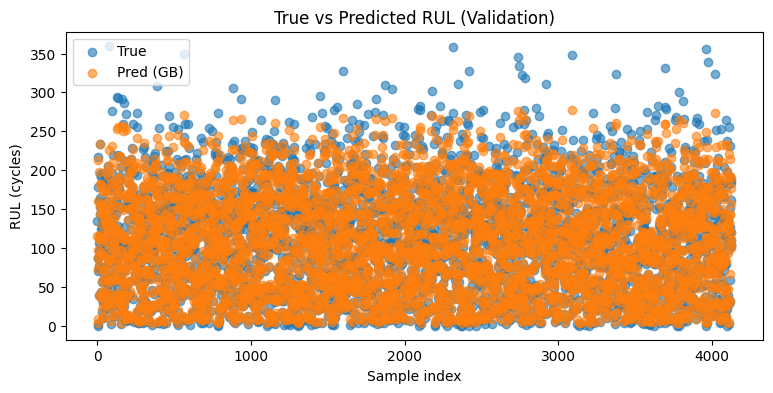

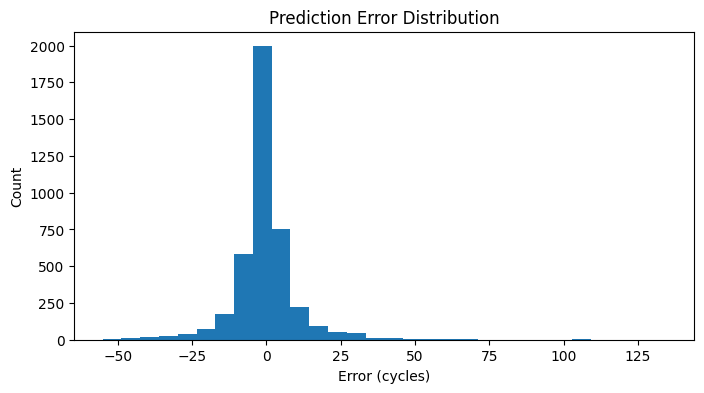

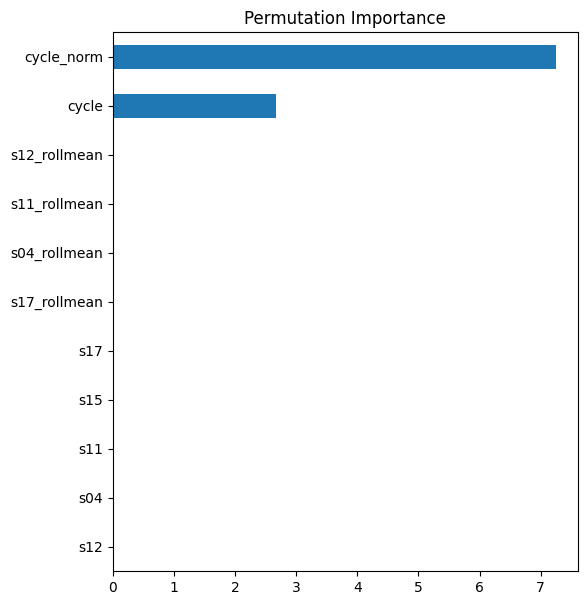

In [10]:

plt.figure(figsize=(9,4))
plt.scatter(range(len(y_va)), y_va, alpha=0.6, label="True")
plt.scatter(range(len(pred_gb)), pred_gb, alpha=0.6, label="Pred (GB)")
plt.title("True vs Predicted RUL (Validation)")
plt.xlabel("Sample index"); plt.ylabel("RUL (cycles)"); plt.legend(); plt.show()

errors = y_va - pred_gb
plt.figure(figsize=(8,4))
plt.hist(errors, bins=30)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (cycles)"); plt.ylabel("Count"); plt.show()

perm = permutation_importance(gb, X_va, y_va, n_repeats=10, random_state=SEED)
imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=True)
imp.plot(kind="barh", figsize=(6,7), title="Permutation Importance"); plt.show()


## 6) Train final model & export artifacts

In [11]:

best = GradientBoostingRegressor(random_state=SEED)
best.fit(X, y)

MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(best, MODEL_DIR / "rul_gb_fd001.joblib")

meta = {
    "dataset": "NASA CMAPSS FD001",
    "features": list(X.columns),
    "cv_splits": 5,
    "seed": SEED,
    "model": "GradientBoostingRegressor",
    "params": best.get_params()
}
with open(MODEL_DIR / "model_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved model:", MODEL_DIR / "rul_gb_fd001.joblib")
print("Saved metadata:", MODEL_DIR / "model_metadata.json")


Saved model: /Users/isawgod/Documents/project/turbofan-rul-prediction/models/rul_gb_fd001.joblib
Saved metadata: /Users/isawgod/Documents/project/turbofan-rul-prediction/models/model_metadata.json


## 7) Sanity-check inference (features + raw)

In [14]:

try:
    from src.predict import predict_rul
except Exception:
    from predict import predict_rul

loaded = joblib.load(MODEL_DIR / "rul_gb_fd001.joblib")

batch = X.head(10).copy()
pred = predict_rul(batch, model=loaded)
print("FE prediction head:"); display(pred.head())

raw_batch = train_raw[["unit","cycle"] + [f"s{i:02d}" for i in range(1,22)]].head(10).copy()
pred_raw = predict_rul(raw_batch, model=loaded, auto_fe=True)
print("RAW prediction head:"); display(pred_raw.head())


FE prediction head:


0    195.634049
1    205.582837
2    210.237493
3    207.922745
4    200.532090
Name: RUL_pred, dtype: float64

RAW prediction head:


0    79.349583
1    29.959686
2     1.309381
3   -35.713968
4   -54.980112
Name: RUL_pred, dtype: float64

## 8) Environment info

In [13]:

import platform, sklearn, pandas as pd, numpy as np
print("Python :", platform.python_version())
print("sklearn:", sklearn.__version__)
print("pandas :", pd.__version__)
print("numpy  :", np.__version__)


Python : 3.10.19
sklearn: 1.7.2
pandas : 2.3.3
numpy  : 2.2.6
